In [2]:
# %%
import torch.utils.data as Data
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.datasets import LFWPeople, LFWPairs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from scipy import ndimage
import numpy as np
from PIL.ImageEnhance import *
from torchvision.transforms import *
import random
from skimage import transform as trans
from mtcnn_pytorch.src import detect_faces, show_bboxes
from PIL import Image
import cv2
import numpy as np
from mtcnn_pytorch.src.align_trans import get_reference_facial_points, warp_and_crop_face

from models.inception_resnet_v1 import InceptionResnetV1

manualSeed=0
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
np.random.RandomState(manualSeed)

# %%
lfw_people = LFWPairs(split='train', root='/home/weicheng/selfLearning/facenet/project/lfw', 
                       download=True, transform=T.Compose([
                T.Resize(size=(250,250)),
                # T.RandomHorizontalFlip(0.5),
                # T.RandomRotation(degrees=10, interpolation=InterpolationMode.BILINEAR),
                T.ToTensor(),
                # T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ]))

# %%
resnet = InceptionResnetV1(classify=False, pretrained='casia-webface')
resnet.logits = torch.nn.Linear(512, 5749)
resnet = resnet.cuda(0)
# resnet.load_state_dict(torch.load("../model/epoch_500.pth"), map_location=lambda storage, loc: storage)
resnet.train()

# %%
loader = Data.DataLoader(
    dataset=lfw_people,
    batch_size=32,
    shuffle=True, drop_last=True)

optimizer = optim.Adam(resnet.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 50, 100, 200, 500])
criterion = torch.nn.CrossEntropyLoss()

# %%
def random_rot_flip(image):
    new_image = []
    for i in range(image.shape[0]):
        k = np.random.randint(0, 4)
        image_i = np.rot90(image[i], k)
        # label = np.rot90(label, k)
        axis = np.random.randint(0, 2)
        image_i = np.flip(image_i, axis=axis).copy()
        new_image.append(np.array(image_i))
    image = np.array(new_image, dtype=np.float64)
    return image

def random_rotate(image):
    new_image = []
    for i in range(image.shape[0]):
        angle = np.random.randint(-20, 20)
        image_i = ndimage.rotate(image[i], angle, order=0, reshape=False)
        new_image.append(np.array(image_i))
    image = np.array(new_image, dtype=np.float64)
    return image


def random_noise(image):
    new_image = []
    sigma = random.uniform(0.15, 1.15)
    for i in range(image.shape[0]):
        image_i = ToPILImage()(image[i]).filter(ImageFilter.GaussianBlur(radius=sigma))
        new_image.append(np.array(image_i))
    image = np.array(new_image, dtype=np.float64)
    return image

# %%
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * torch.nn.functional.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

# %%
def accuracy(outputs, labels):
    total = 0
    correct = 0
    _, predicted = torch.max(outputs.data, 1) ##
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    return correct/total


def process_ndarray(img1_cv2):
    for i in range(img1_cv2.shape[0]):
        # print(img1_cv2[i].squeeze().shape) # (160, 160, 3)
        img = img1_cv2[i].squeeze() * 255
        img = img.astype(np.uint8)
        img = Image.fromarray(img)
        # print(img.size)
        src = np.array([                                                                                                                                                                     
            [30.2946, 51.6963],                                                                                                                                                                
            [65.5318, 51.5014],                                                                                                                                                                
            [48.0252, 71.7366],                                                                                                                                                                
            [33.5493, 92.3655],                                                                                                                                                                
            [62.7299, 92.2041] ], dtype=np.float32 )
        src[:,0] *= (img.size[0]/96)
        src[:,1] *= (img.size[1]/112)
        _, landmarks = detect_faces(img)
        # print(landmarks)
        dst = landmarks[0].astype(np.float32)
        facial5points = [[dst[j],dst[j+5]] for j in range(5)]
        tform = trans.SimilarityTransform()                                                                                                                     
        tform.estimate(np.array(facial5points), src)
        M = tform.params[0:2,:]
        warped = cv2.warpAffine(img1_cv2[i].squeeze(),M,(img.size[0],img.size[1]), borderValue = 0.0)
        # print(warped.shape)
        # print(np.max(warped))
        img1_cv2[i] = warped
    return img1_cv2
# %%
contra = ContrastiveLoss(margin=1)

Files already downloaded and verified


In [2]:
lfw_people = LFWPairs(root='/mnt/NAS/home/weicheng/selfLearning/facenet/project/lfw', 
                       download=True, transform=T.Compose([
                T.Resize(size=(160,160)),
                T.RandomHorizontalFlip(0.5),
                T.RandomRotation(degrees=10, interpolation=InterpolationMode.BILINEAR),
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ]))

Files already downloaded and verified


In [3]:
resnet = InceptionResnetV1(classify=False, pretrained='casia-webface')
resnet.logits = torch.nn.Linear(512, 5749)
resnet = resnet.cuda(0)
resnet.train()

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [4]:
loader = Data.DataLoader(
    dataset=lfw_people,
    batch_size=32,
    shuffle=True, drop_last=True)

optimizer = optim.Adam(resnet.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 50])
criterion = torch.nn.CrossEntropyLoss()

In [8]:
def random_rot_flip(image):
    new_image = []
    for i in range(image.shape[0]):
        k = np.random.randint(0, 4)
        image_i = np.rot90(image[i], k)
        # label = np.rot90(label, k)
        axis = np.random.randint(0, 2)
        image_i = np.flip(image_i, axis=axis).copy()
        new_image.append(np.array(image_i))
    image = np.array(new_image, dtype=np.float64)
    return image

def random_rotate(image):
    new_image = []
    for i in range(image.shape[0]):
        angle = np.random.randint(-20, 20)
        image_i = ndimage.rotate(image[i], angle, order=0, reshape=False)
        new_image.append(np.array(image_i))
    image = np.array(new_image, dtype=np.float64)
    return image


def random_noise(image):
    new_image = []
    sigma = random.uniform(0.15, 1.15)
    for i in range(image.shape[0]):
        image_i = ToPILImage()(image[i]).filter(ImageFilter.GaussianBlur(radius=sigma))
        new_image.append(np.array(image_i))
    image = np.array(new_image, dtype=np.float64)
    return image

In [9]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * torch.nn.functional.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [7]:
def accuracy(outputs, labels):
    total = 0
    correct = 0
    _, predicted = torch.max(outputs.data, 1) ##
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    return correct/total

  0%|          | 0/187 [00:00<?, ?it/s]

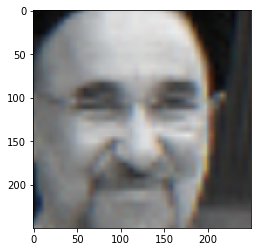

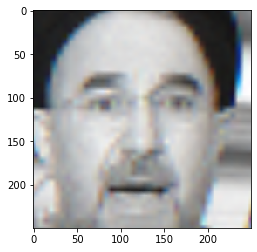

  0%|          | 0/187 [00:03<?, ?it/s]

tensor(1, device='cuda:0')


In [7]:
for epoch in range(1):
    list_loss = []
    # list_acc = []
    for step, (batch_x, batch_y, target) in enumerate(tqdm(loader)):
        # inputs, labels = batch_x, batch_y
        # inputs, labels = inputs.cuda(0), labels.cuda(0)
        img1, img2, target = batch_x, batch_y, target.cuda()
        img1 = img1.view(img1.shape[0], img1.shape[2], img1.shape[3], img1.shape[1])
        img2 = img2.view(img2.shape[0], img2.shape[2], img2.shape[3], img2.shape[1])
        img1_cv2 = img1.numpy()
        img2_cv2 = img2.numpy()
        img1_cv2 = process_ndarray(img1_cv2)
        # print(img1_cv2.shape)
        plt.imshow(img1_cv2[0])
        plt.show()
        img2_cv2 = process_ndarray(img2_cv2)
        plt.imshow(img2_cv2[0])
        plt.show()
        print(target[0])
        break
        img1 = torch.FloatTensor(img1_cv2)
        img1 = img1.view(img1.shape[0], img1.shape[3], img1.shape[1], img1.shape[2])
        img2 = torch.FloatTensor(img2_cv2)
        img2 = img2.view(img2.shape[0], img2.shape[3], img2.shape[1], img2.shape[2])
        pred1, fea1 = resnet(img1.cuda())
        pred2, fea2 = resnet(img2.cuda())
        # pred_softmax = torch.softmax(pred, dim=-1)
        loss = contra(fea1, fea2, target)
        list_loss.append(loss.item())
        # list_acc.append(accuracy(outputs=pred_softmax, labels=labels))
        loss.backward()
        optimizer.step()
        scheduler.step()
    break
    print('loss in epoch {} is '.format(epoch), sum(list_loss)/len(list_loss))
    # print('acc in epoch {} is '.format(epoch), sum(list_acc)/len(list_acc))
    if(epoch%10==0):
        save_mode_path = os.path.join('../model_mtcnn', 'epoch_' + str(epoch) + '.pth')
        torch.save(resnet.state_dict(), save_mode_path)